In [1]:
%reload_ext autoreload
%autoreload 2

In [67]:
import segmenter as pb
import sam3d as s3d
import open3d as o3d
from psdframe import Frame
from psdstaticdataset import StaticDataset
from pathlib import Path
from matplotlib import pyplot as plt
from segment_anything import build_sam, SamAutomaticMaskGenerator
from util import Voxelize, num_to_natural
from mesh_to_gaussians import batch_triangles_to_splats, splats_to_oriented_discs
import numpy as np
from initializerdefs import SceneSetup
from typing import List

In [4]:
import logging
ch = logging.StreamHandler()
pb.logger.setLevel(logging.DEBUG)
pb.logger.addHandler(ch)

In [73]:
DS_PATH = Path("/home/david/projects/embodied_gaussians/datasets/real/multiple1_aruco/modelling/static")
#DS_PATH = Path("/home/david/projects/embodied_gaussians/datasets/simulated/multiple_1/modelling/static")
d = StaticDataset(DS_PATH / "transforms.json")

frames = d.frames
mask_generator = SamAutomaticMaskGenerator(build_sam(checkpoint=pb.sam_checkpoint).to(device="cuda"))
voxelize = Voxelize(voxel_size=pb.VOXEL_SIZE, mode="train", keys=("coord", "color", "group", "normals"))
intermediate_outputs_path = Path("/home/david/projects/SegmentAnything3D/outputs/notebook")
scene = SceneSetup.load(DS_PATH / "scene.pkl")
bbox = pb.get_scene_bounding_box(scene)


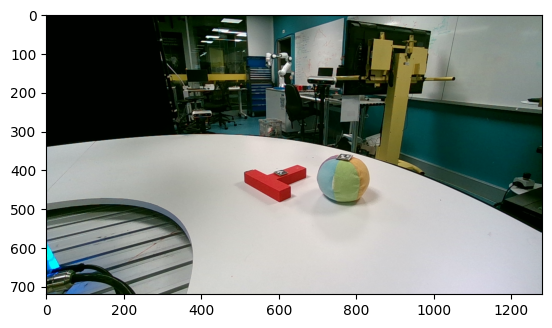

In [77]:
plt.imshow(frames[0].color.cpu().numpy())
plt.show()


In [78]:
pcd_dict = pb.seg_pcd(d, mask_generator, voxelize, bbox=bbox, intermediate_outputs_path=intermediate_outputs_path)


merging 5 point clouds
merging 3 point clouds
merging 2 point clouds


In [79]:
# create colors from group
group_colors = np.zeros((pcd_dict['group'].shape[0], 3))
unique_groups = np.unique(pcd_dict['group'])
for i, group in enumerate(unique_groups):
    group_colors[pcd_dict['group'] == group] = plt.cm.tab20(i % 20)[:3]

bbox.color = [1.0,0,0]
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pcd_dict['coord'])
pcd.colors = o3d.utility.Vector3dVector(group_colors )
o3d.visualization.draw_geometries([pcd,bbox ])

In [83]:
object_groups, table_group = pb.extract_object_and_table_groups(pcd_dict, d, scene)


Valid groups: [2, 4, 5, 6, 7, 8, 9, 10, 24, 27, 30, 31, 32, 34, 35, 36, 40, 43, 44, 53, 61]
removed : 43 groups
Table group: 7


In [86]:
# create point cloud from pcd_dict where group is 2
object_group = 5
new_dict = {    
    "coord": pcd_dict['coord'][pcd_dict['group'] == object_group],
    "color": group_colors[pcd_dict['group'] == object_group],
    "group": pcd_dict['group'][pcd_dict['group'] == object_group],
    "normals": pcd_dict['normals'][pcd_dict['group'] == object_group]
}


pcd_group2 = o3d.geometry.PointCloud()
pcd_group2.points = o3d.utility.Vector3dVector(new_dict['coord'])
pcd_group2.colors = o3d.utility.Vector3dVector(new_dict['color'])
pcd_group2.normals = o3d.utility.Vector3dVector(new_dict['normals'])
o3d.visualization.draw_geometries([pcd_group2,bbox])


In [92]:
import pymeshfix

In [105]:
# try make a nice mesh
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd_group2, depth=7)
# remove where density is lower than 90th percentile
vertices_to_remove = densities < np.quantile(densities, 0.07)
mesh.remove_vertices_by_mask(vertices_to_remove)


new_vert, new_triangles = pymeshfix.clean_from_arrays(np.asarray(mesh.vertices), np.asarray(mesh.triangles))
mesh.vertices = o3d.utility.Vector3dVector(new_vert)
mesh.triangles = o3d.utility.Vector3iVector(new_triangles)

o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)


[WARNING] /root/Open3D/build/poisson/src/ext_poisson/PoissonRecon/Src/FEMTree.Initialize.inl (Line 193)
          Initialize
          Found bad data: 1


In [60]:
mesh = pb.construct_mesh(pcd_dict)
o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

[WARNING] /root/Open3D/build/poisson/src/ext_poisson/PoissonRecon/Src/FEMTree.Initialize.inl (Line 193)
          Initialize
          Found bad data: 241


In [61]:
meshes = pb.get_object_meshes(pcd_dict, d, scene)

# iterate over meshes and give each a color
for i, mesh in enumerate(meshes):
    mesh.paint_uniform_color(plt.cm.tab20(i % 20)[:3])

o3d.visualization.draw_geometries(meshes, mesh_show_back_face=True)


Valid groups: [0, 1, 2]
removed : 3 groups
Table group: 2
[WARNING] /root/Open3D/build/poisson/src/ext_poisson/PoissonRecon/Src/FEMTree.Initialize.inl (Line 193)
          Initialize
          Found bad data: 239


In [62]:

clean_meshes = [pb.clean_and_watertight_mesh(mesh) for mesh in meshes]
# iterate over meshes and give each a color
for i, mesh in enumerate(clean_meshes):
    mesh.paint_uniform_color(plt.cm.tab20(i % 20)[:3])
o3d.visualization.draw_geometries(clean_meshes, mesh_show_back_face=True)

In [63]:
tblock = clean_meshes[0]
tblock.compute_triangle_normals()
o3d.visualization.draw_geometries([tblock], mesh_show_back_face=True)

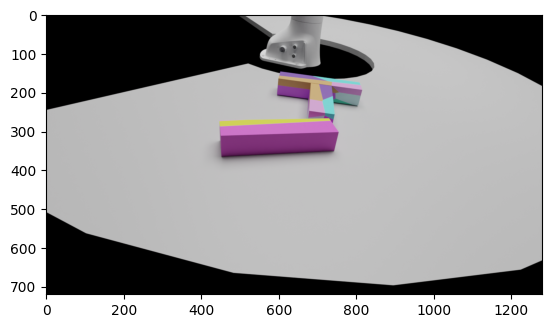

In [64]:
# we want to project the meshes so that we get an instance masks
frame = frames[4]

plt.imshow(frame.color.cpu().numpy())
plt.show()


In [65]:
from mesh_to_particles import render_from_frame

def render_mesh(vis, mesh: o3d.geometry.TriangleMesh):
    mesh.paint_uniform_color([1.0,0,0])
      # Get render option object
    render_option = vis.get_render_option()
    
    render_option.point_show_normal = False
    render_option.mesh_show_wireframe = False
    render_option.mesh_show_back_face = False
    
    # Additional settings that can affect aliasing
    render_option.light_on = False

    vis.add_geometry(mesh)
    
def mask_from_frame(frame: Frame, mesh: o3d.geometry.TriangleMesh):
    _, depth = render_from_frame(frame, lambda vis: render_mesh(vis, mesh))
    mask = depth > 0
    return mask, depth


In [69]:
def instance_for_frame(frame: Frame, meshes: List[o3d.geometry.TriangleMesh]):
    depths = []
    masks = []
    for mesh in meshes:
        mask, depth = mask_from_frame(frame, mesh)
        masks.append(mask)
        depths.append(depth)
    
    # create a new image with the same shape as the depth image
    instances = np.zeros((depths[0].shape[0], depths[0].shape[1]), dtype=int)
    instance_depths = np.zeros((depths[0].shape[0], depths[0].shape[1]), dtype=float)
    for id, (depth, mask) in enumerate(zip(depths, masks)):
        # update the instances in instances where the depth is less than the current instance depth
        # where mask is True and depth is less than instance_depths or instance_depths is 0
        update_mask = mask & ((depth < instance_depths) | (instance_depths == 0))
        instances[update_mask] = id + 1  # use 1-based indexing for instances
        instance_depths[update_mask] = depth[update_mask]
    return instances


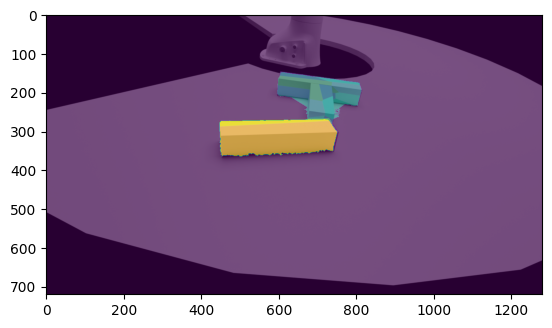

In [70]:
instances = instance_for_frame(frame, clean_meshes)
#color, depth = render_from_frame(frame, lambda vis: render_mesh(vis, tblock))
plt.imshow(frame.color.cpu().numpy())
# overlay color image on top at 0.2 opacity
plt.imshow(instances , alpha=0.6)
plt.show()

In [71]:
np.unique(instances.reshape(-1,1), axis=0)

array([[0],
       [1],
       [2]])

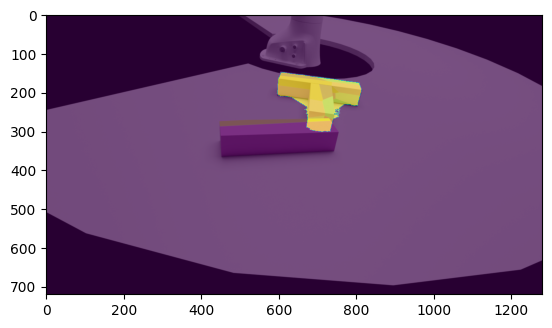

In [66]:
mask, depth = mask_from_frame(frame, tblock)

#color, depth = render_from_frame(frame, lambda vis: render_mesh(vis, tblock))
plt.imshow(frame.color.cpu().numpy())
# overlay color image on top at 0.2 opacity
plt.imshow(mask , alpha=0.6)
plt.show()


In [46]:
np.unique(mask)

array([False,  True])

In [43]:
# ensure we are solid integers
np.unique(color.reshape(-1,3),axis=0)

array([[0.12156863, 0.46666667, 0.7058824 ],
       [1.        , 1.        , 1.        ]], dtype=float32)

In [16]:
triangles = np.asarray(np.asarray(tblock.vertices)[tblock.triangles])
triangle_normals = np.asarray(tblock.triangle_normals)
splats = batch_triangles_to_splats(triangles, triangle_normals)
splats['centers'].shape, splats['scales'].shape, splats['rotations'].shape

((10856, 3), (10856, 3), (10856, 4))

In [17]:
discs = splats_to_oriented_discs(splats['centers'], splats['scales'], splats['rotations'])
o3d.visualization.draw_geometries(discs, mesh_show_back_face=True)

: 

In [ ]:
# visualize a box
box = o3d.geometry.TriangleMesh.create_box(0.5,0.5,0.5)
box.compute_triangle_normals()
triangles = np.asarray(np.asarray(box.vertices)[box.triangles])
triangle_normals = np.asarray(box.triangle_normals)

splats = batch_triangles_to_splats(triangles, triangle_normals)
discs = splats_to_oriented_discs(splats['centers'], splats['scales'], splats['rotations'])

o3d.visualization.draw_geometries([box, *discs], mesh_show_back_face=True)